# Surrogate Optimization - Chapter 19
## Bayesian Optimization and SafeOpt

Demo of Surrogate Optimization techniques from **Algorithms for Optimization**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import json
import os
from datetime import datetime

from ipywidgets import interact, IntSlider, Dropdown, FloatSlider, interactive_output, VBox, HBox, widgets
from IPython.display import display, clear_output

from gaussian_process import GaussianProcess, VIZ_CONFIG, COLORS
from acquisition_functions import (
    probability_of_improvement,
    expected_improvement,
    lower_confidence_bound
)
from surrogate_optimization import SurrogateOptimizer
from safe_optimization import SafeOpt

plt.rcParams.update(VIZ_CONFIG)

OUTPUT_DIR = "output_notebook"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Test Function Library

Various test functions for optimization


In [2]:
TEST_FUNCTIONS = {
    'sin_cos': {
        'name': 'Sin + Cos',
        'func': lambda x: np.sin(x) + 0.3 * np.cos(2 * x),
        'bounds': (-1, 7),
        'description': 'sin(x) + 0.3*cos(2x) - simple, multiple local minima'
    },
    'quadratic': {
        'name': 'Quadratic',
        'func': lambda x: (x - 2) ** 2 / 40 - 0.5,
        'bounds': (-5, 5),
        'description': '(x-2)^2/40 - 0.5 - quadratic, single minimum'
    },
    'forrester': {
        'name': 'Forrester',
        'func': lambda x: (6*x - 2)**2 * np.sin(12*x - 4),
        'bounds': (0, 1),
        'description': 'Forrester function - common BO benchmark'
    },
    'branin': {
        'name': 'Branin (1D slice)',
        'func': lambda x: (x - 5.1/(4*np.pi**2) * x**2 + 5/np.pi * x - 6)**2,
        'bounds': (-5, 10),
        'description': 'Branin function (1D) - multiple minima'
    },
    'gramacy_lee': {
        'name': 'Gramacy & Lee',
        'func': lambda x: np.sin(10*np.pi*x) / (2*x) + (x - 1)**4,
        'bounds': (0.5, 2.5),
        'description': 'Gramacy & Lee function - high oscillation'
    },
    'michalewicz': {
        'name': 'Michalewicz (1D)',
        'func': lambda x: -np.sin(x) * (np.sin(x**2 / np.pi))**20,
        'bounds': (0, np.pi),
        'description': 'Michalewicz function - many deep minima'
    },
    'safe_test': {
        'name': 'Safe Test',
        'func': lambda x: np.sin(2 * x) + 0.3 * x,
        'bounds': (-3, 3),
        'description': 'Function for SafeOpt - has unsafe regions'
    }
}

def get_test_function(name):
    if name not in TEST_FUNCTIONS:
        raise ValueError(f"Function '{name}' not found. Available: {list(TEST_FUNCTIONS.keys())}")
    return TEST_FUNCTIONS[name]

print("Available test functions:")
for key, info in TEST_FUNCTIONS.items():
    print(f"\t[{key:15s}] {info['name']:20s} - {info['description']}")


Available test functions:
	[sin_cos        ] Sin + Cos            - sin(x) + 0.3*cos(2x) - simple, multiple local minima
	[quadratic      ] Quadratic            - (x-2)^2/40 - 0.5 - quadratic, single minimum
	[forrester      ] Forrester            - Forrester function - common BO benchmark
	[branin         ] Branin (1D slice)    - Branin function (1D) - multiple minima
	[gramacy_lee    ] Gramacy & Lee        - Gramacy & Lee function - high oscillation
	[michalewicz    ] Michalewicz (1D)     - Michalewicz function - many deep minima
	[safe_test      ] Safe Test            - Function for SafeOpt - has unsafe regions


## INTERACTIVE: GP Evolution with Observations

Use the slider to see how the GP model changes as observations are added


In [3]:
# ===== INTERACTIVE GP VISUALIZATION =====

class InteractiveGP:
    """Interactive Gaussian Process visualization với slider"""
    
    def __init__(self, func_name='sin_cos', n_total_points=10, random_seed=42):
        self.func_info = get_test_function(func_name)
        self.true_func = self.func_info['func']
        self.bounds = self.func_info['bounds']
        self.n_total_points = n_total_points
        
        # Tạo tất cả training points trước
        np.random.seed(random_seed)
        self.X_all = np.random.uniform(
            self.bounds[0], self.bounds[1], 
            size=(n_total_points, 1)
        )
        self.X_all = np.sort(self.X_all, axis=0)  # Sort để dễ nhìn
        self.y_all = self.true_func(self.X_all) + np.random.normal(0, 0.1, self.X_all.shape)
        
        # Test points
        self.X_test = np.linspace(self.bounds[0], self.bounds[1], 200).reshape(-1, 1)
        self.y_test_true = self.true_func(self.X_test)
        
        # GP model
        self.gp = GaussianProcess(length_scale=0.5, noise=0.01)
        
    def plot_gp_at_step(self, n_points):
        """Vẽ GP với n_points đầu tiên"""
        
        if n_points < 1:
            n_points = 1
        if n_points > self.n_total_points:
            n_points = self.n_total_points
            
        # Lấy n_points đầu tiên
        X_train = self.X_all[:n_points]
        y_train = self.y_all[:n_points]
        
        # Fit GP
        self.gp.fit(X_train, y_train)
        y_pred, y_std = self.gp.predict(self.X_test)
        
        # Visualization
        fig, ax = plt.subplots(figsize=(14, 7))
        
        ax.plot(self.X_test, self.y_test_true,
                color=COLORS['true_function'], linestyle='--',
                label='True Function', linewidth=2.5, zorder=2)
        
        ax.plot(self.X_test, y_pred,
                color=COLORS['prediction'],
                label='GP Mean', linewidth=2.5, zorder=3)
        
        ax.fill_between(self.X_test.flatten(),
                        y_pred - 2*y_std, y_pred + 2*y_std,
                        alpha=0.3, color=COLORS['confidence'],
                        label='95% CI', zorder=1)
        
        ax.scatter(X_train, y_train,
                   c=COLORS['observed'], s=150, zorder=5,
                   label=f'Observations ({n_points}/{self.n_total_points})',
                   edgecolors='white', linewidths=2.5)
        
        if n_points < self.n_total_points:
            X_future = self.X_all[n_points:]
            y_future = self.y_all[n_points:]
            ax.scatter(X_future, y_future,
                       c='gray', s=80, alpha=0.3, zorder=4,
                       marker='x', linewidths=2,
                       label=f'Unobserved ({self.n_total_points - n_points})')
        
        ax.set_xlabel('x', fontsize=15, fontweight='bold')
        ax.set_ylabel('y', fontsize=15, fontweight='bold')
        ax.set_title(f'Gaussian Process - Step {n_points}/{self.n_total_points}\n'
                     f'Function: {self.func_info["name"]}',
                     fontsize=18, fontweight='bold', pad=20)
        ax.legend(fontsize=12, loc='best', framealpha=0.95)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Step {n_points}/{self.n_total_points}")
        print(f"\t- Observations: {n_points}")
        print(f"\t- Mean uncertainty: {np.mean(y_std):.4f}")
        print(f"\t- Max uncertainty: {np.max(y_std):.4f}")
        
    def create_interactive(self):
        """Tạo interactive widget"""
        slider = IntSlider(
            value=1,
            min=1,
            max=self.n_total_points,
            step=1,
            description='N points:',
            continuous_update=False,
            style={'description_width': '100px'}
        )
        
        interact(self.plot_gp_at_step, n_points=slider)

interactive_gp = InteractiveGP(func_name='sin_cos', n_total_points=10, random_seed=42)

In [4]:
interactive_gp.create_interactive()

interactive(children=(IntSlider(value=1, continuous_update=False, description='N points:', max=10, min=1, styl…

## INTERACTIVE: Bayesian Optimization Process

Watch each step of Bayesian Optimization with acquisition functions


In [5]:
# ===== INTERACTIVE BAYESIAN OPTIMIZATION =====

class InteractiveBO:
    """Interactive Bayesian Optimization visualization"""
    
    def __init__(self, func_name='quadratic', n_init=3, n_iter=15, 
                 acquisition='ei', random_seed=42):
        self.func_info = get_test_function(func_name)
        self.objective = self.func_info['func']
        self.bounds = self.func_info['bounds']
        self.n_init = n_init
        self.n_iter = n_iter
        self.acquisition = acquisition
        
        # Chạy optimization để lấy history
        np.random.seed(random_seed)
        optimizer = SurrogateOptimizer(
            objective_func=self.objective,
            bounds=[self.bounds],
            acquisition=acquisition,
            gp_params={'length_scale': 0.5, 'noise': 1e-6}
        )
        
        self.X_best, self.y_best, self.history = optimizer.optimize(
            n_init=n_init,
            n_iter=n_iter,
            random_state=random_seed,
            verbose=False
        )
        
        # Test points
        self.X_test = np.linspace(self.bounds[0], self.bounds[1], 200).reshape(-1, 1)
        self.y_test = self.objective(self.X_test)
        
        self.total_steps = n_init + n_iter
        
    def plot_bo_at_iteration(self, iteration):
        """Vẽ BO tại iteration cụ thể"""
        
        if iteration < self.n_init:
            iteration = self.n_init
        if iteration > self.total_steps:
            iteration = self.total_steps
            
        # Lấy dữ liệu đến iteration này
        all_X_list = []
        all_y_list = []
        for i in range(iteration):
            if i < len(self.history['X']):
                all_X_list.append(self.history['X'][i])
                all_y_list.append(self.history['y'][i])
        
        all_X = np.concatenate(all_X_list)
        all_y = np.concatenate(all_y_list)
        
        gp = GaussianProcess(length_scale=0.5, noise=1e-6)
        X_train_norm = (all_X - self.bounds[0]) / (self.bounds[1] - self.bounds[0])
        gp.fit(X_train_norm.reshape(-1, 1), all_y)
        
        X_test_norm = (self.X_test - self.bounds[0]) / (self.bounds[1] - self.bounds[0])
        mean, std = gp.predict(X_test_norm)
        
        y_best_current = np.min(all_y)
        if self.acquisition == 'ei':
            acq = expected_improvement(mean, std, y_best_current)
            acq_name = 'EI'
        elif self.acquisition == 'pi':
            acq = probability_of_improvement(mean, std, y_best_current)
            acq_name = 'PI'
        else:
            acq = -lower_confidence_bound(mean, std, alpha=2.0)
            acq_name = 'LCB'
        
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        ax = axes[0]
        ax.plot(self.X_test, self.y_test,
                color=COLORS['true_function'], linestyle='--',
                label='Objective', linewidth=2.5, alpha=0.7)
        
        ax.plot(self.X_test, mean,
                color=COLORS['prediction'],
                label='GP Mean', linewidth=2.5)
        
        ax.fill_between(self.X_test.flatten(),
                        mean - 2*std, mean + 2*std,
                        alpha=0.3, color=COLORS['confidence'],
                        label='95% CI')
        
        ax.scatter(all_X[:self.n_init], all_y[:self.n_init],
                   c=COLORS['prediction'], s=120, marker='o',
                   label='Initial', zorder=5,
                   edgecolors='white', linewidths=2)
        
        if iteration > self.n_init:
            ax.scatter(all_X[self.n_init:], all_y[self.n_init:],
                       c=COLORS['safe'], s=120, marker='^',
                       label='BO samples', zorder=5,
                       edgecolors='white', linewidths=2)
        
        best_idx = np.argmin(all_y)
        ax.scatter([all_X[best_idx]], [all_y[best_idx]],
                   c=COLORS['highlight'], s=300, marker='*',
                   label='Best so far', zorder=6,
                   edgecolors=COLORS['observed'], linewidths=3)
        
        ax.set_xlabel('x', fontsize=14, fontweight='bold')
        ax.set_ylabel('f(x)', fontsize=14, fontweight='bold')
        ax.set_title(f'Bayesian Optimization - Iteration {iteration}/{self.total_steps}',
                     fontsize=16, fontweight='bold', pad=15)
        ax.legend(fontsize=11, framealpha=0.95)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        ax = axes[1]
        ax.plot(self.X_test, acq,
                color=COLORS['acquisition'], linewidth=3,
                label=f'{acq_name} function')
        
        if iteration < self.total_steps:
            next_idx = np.argmax(acq) if self.acquisition != 'lcb' else np.argmin(-acq)
            ax.axvline(self.X_test[next_idx],
                       color=COLORS['highlight'], linestyle='--',
                       linewidth=2.5, label='Next point')
            ax.scatter([self.X_test[next_idx]], [acq[next_idx]],
                       c=COLORS['highlight'], s=200, zorder=5,
                       edgecolors=COLORS['observed'], linewidths=2.5)
        
        ax.set_xlabel('x', fontsize=14, fontweight='bold')
        ax.set_ylabel(f'{acq_name}(x)', fontsize=14, fontweight='bold')
        ax.set_title(f'Acquisition Function: {acq_name}',
                     fontsize=16, fontweight='bold', pad=15)
        ax.legend(fontsize=11, framealpha=0.95)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Iteration {iteration}/{self.total_steps}")
        print(f"\t- Sampled points: {len(all_X)}")
        print(f"\t- Current best f(x): {np.min(all_y):.6f}")
        best_x = all_X[np.argmin(all_y)]
        best_x_val = float(best_x) if np.isscalar(best_x) else float(best_x.flatten()[0])
        print(f"\t- Current best x: {best_x_val:.4f}")
        
    def create_interactive(self):
        """Create interactive widget"""
        slider = IntSlider(
            value=self.n_init,
            min=self.n_init,
            max=self.total_steps,
            step=1,
            description='Iteration:',
            continuous_update=False,
            style={'description_width': '100px'}
        )
        
        interact(self.plot_bo_at_iteration, iteration=slider)

interactive_bo = InteractiveBO(
    func_name='quadratic',
    n_init=3,
    n_iter=12,
    acquisition='ei',
    random_seed=42
)

In [6]:
interactive_bo.create_interactive()


interactive(children=(IntSlider(value=3, continuous_update=False, description='Iteration:', max=15, min=3, sty…

## PLAYGROUND: Experiment with Different Functions


In [7]:
class InteractivePlayground:
    """Interactive playground for testing different functions and acquisition functions"""
    
    def __init__(self):
        self.functions = {
            'sin_cos': get_test_function('sin_cos'),
            'quadratic': get_test_function('quadratic'),
            'forrester': get_test_function('forrester'),
            'branin': get_test_function('branin'),
            'gramacy_lee': get_test_function('gramacy_lee'),
            'michalewicz': get_test_function('michalewicz')
        }
        
        self.acq_functions = {
            'PI': ('Probability of Improvement', probability_of_improvement),
            'EI': ('Expected Improvement', expected_improvement),
            'LCB': ('Lower Confidence Bound', lower_confidence_bound)
        }
    
    def run_optimization(self, func_name, acq_name, n_initial, n_iterations, random_seed):
        """Run Bayesian Optimization with selected settings"""
        
        func_info = self.functions[func_name]
        true_func = func_info['func']
        bounds = func_info['bounds']
        
        np.random.seed(random_seed)
        X_init = np.random.uniform(bounds[0], bounds[1], (n_initial, 1))
        y_init = true_func(X_init) + np.random.normal(0, 0.1, (n_initial, 1))
        
        # Tạo optimizer
        acq_func_name, acq_func = self.acq_functions[acq_name]
        optimizer = SurrogateOptimizer(
            bounds=bounds,
            acquisition_func=acq_func,
            length_scale=0.5,
            noise=0.01
        )
        
        # Thêm initial observations
        for i in range(len(X_init)):
            optimizer.add_observation(X_init[i], y_init[i])
        
        # Chạy optimization
        for _ in range(n_iterations):
            X_next = optimizer.suggest_next()
            y_next = true_func(X_next) + np.random.normal(0, 0.1)
            optimizer.add_observation(X_next, y_next)
        
        # Visualization
        X_plot = np.linspace(bounds[0], bounds[1], 200).reshape(-1, 1)
        y_true = true_func(X_plot)
        
        mean, std = optimizer.gp.predict(X_plot)
        
        # Tính acquisition values
        y_best = optimizer.get_best_y()
        acq_values = acq_func(mean.flatten(), std.flatten(), y_best)
        
        # Plot
        fig = plt.figure(figsize=(14, 10))
        gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1], hspace=0.3)
        
        # Main plot: Function + GP
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(X_plot, y_true, '--', color=COLORS['true_function'], 
                label='Hàm thực', linewidth=2.5, alpha=0.8)
        ax1.plot(X_plot, mean, color=COLORS['prediction'], 
                label='GP Mean', linewidth=2.5)
        ax1.fill_between(X_plot.flatten(), mean - 2*std, mean + 2*std,
                         alpha=0.3, color=COLORS['confidence'])
        
        # Plot observations
        X_obs = optimizer.X
        y_obs = optimizer.y
        ax1.scatter(X_obs[:n_initial], y_obs[:n_initial], 
                   c=COLORS['observed'], s=150, zorder=5, 
                   label='Initial points', edgecolors='white', linewidths=2)
        ax1.scatter(X_obs[n_initial:], y_obs[n_initial:], 
                   c='red', s=150, zorder=5, marker='*',
                   label='BO points', edgecolors='white', linewidths=2)
        
        # Mark best point
        best_idx = np.argmin(y_obs)
        ax1.scatter(X_obs[best_idx], y_obs[best_idx], 
                   c='gold', s=300, zorder=6, marker='*',
                   label='Best point', edgecolors='black', linewidths=2)
        
        ax1.set_xlabel('x', fontsize=14, fontweight='bold')
        ax1.set_ylabel('y', fontsize=14, fontweight='bold')
        ax1.set_title(f'{func_info["name"]} + {acq_func_name}', 
                     fontsize=16, fontweight='bold')
        ax1.legend(loc='best', fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Acquisition function plot
        ax2 = fig.add_subplot(gs[1])
        ax2.plot(X_plot, acq_values, color='purple', linewidth=2.5)
        ax2.fill_between(X_plot.flatten(), 0, acq_values, alpha=0.3, color='purple')
        ax2.set_xlabel('x', fontsize=12, fontweight='bold')
        ax2.set_ylabel(acq_name, fontsize=12, fontweight='bold')
        ax2.set_title(f'Acquisition Function: {acq_func_name}', fontsize=14)
        ax2.grid(True, alpha=0.3)
        
        # Convergence plot
        ax3 = fig.add_subplot(gs[2])
        best_so_far = np.minimum.accumulate(y_obs.flatten())
        ax3.plot(range(len(best_so_far)), best_so_far, 
                color='green', linewidth=2.5, marker='o')
        ax3.axhline(y=np.min(y_true), color='red', linestyle='--', 
                   label='True minimum', linewidth=2)
        ax3.set_xlabel('Iteration', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Best y', fontsize=12, fontweight='bold')
        ax3.set_title('Convergence', fontsize=14)
        ax3.legend(loc='best')
        ax3.grid(True, alpha=0.3)
        
        plt.show()
        
        # Print results
        print(f"\n{'='*60}")
        print(f"KẾT QUẢ OPTIMIZATION")
        print(f"{'='*60}")
        print(f"Hàm: {func_info['name']}")
        print(f"Acquisition: {acq_func_name}")
        print(f"Initial points: {n_initial}")
        print(f"BO iterations: {n_iterations}")
        print(f"{'='*60}")
        print(f"Best x: {X_obs[best_idx][0]:.4f}")
        print(f"Best y: {y_obs[best_idx][0]:.4f}")
        print(f"True minimum: {np.min(y_true):.4f}")
        print(f"Error: {abs(y_obs[best_idx][0] - np.min(y_true)):.4f}")
        print(f"{'='*60}\n")

playground = InteractivePlayground()


In [8]:
def create_interactive(self):
    """Tạo interactive widget"""
    
    # Function selection
    func_names = list(self.functions.keys())
    func_descriptions = [self.functions[f]['name'] for f in func_names]
    func_dropdown = widgets.Dropdown(
        options=list(zip(func_descriptions, func_names)),
        value='sin_cos',
        description='Function:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='400px')
    )
    
    # Acquisition function selection
    acq_names = list(self.acq_functions.keys())
    acq_descriptions = [self.acq_functions[a][0] for a in acq_names]
    acq_dropdown = widgets.Dropdown(
        options=list(zip(acq_descriptions, acq_names)),
        value='EI',
        description='Acquisition:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='400px')
    )
    
    # Number of initial points
    n_initial_slider = widgets.IntSlider(
        value=5,
        min=3,
        max=10,
        step=1,
        description='Initial points:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='400px')
    )
    
    # Number of BO iterations
    n_iter_slider = widgets.IntSlider(
        value=10,
        min=5,
        max=20,
        step=1,
        description='BO iterations:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='400px')
    )
    
    # Random seed
    seed_slider = widgets.IntSlider(
        value=42,
        min=0,
        max=100,
        step=1,
        description='Random seed:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='400px')
    )
    
    # Run button
    run_button = widgets.Button(
        description='Run Optimization',
        button_style='success',
        layout=widgets.Layout(width='200px', height='40px')
    )
    
    output = widgets.Output()
    
    def on_run_clicked(b):
        output.clear_output(wait=True)
        with output:
            self.run_optimization(
                func_dropdown.value,
                acq_dropdown.value,
                n_initial_slider.value,
                n_iter_slider.value,
                seed_slider.value
            )
    
    run_button.on_click(on_run_clicked)
    
    # Layout
    controls = widgets.VBox([
        widgets.HTML('<h3>PLAYGROUND: Thử nghiệm Bayesian Optimization</h3>'),
        widgets.HTML('<hr>'),
        func_dropdown,
        acq_dropdown,
        n_initial_slider,
        n_iter_slider,
        seed_slider,
        widgets.HTML('<br>'),
        run_button
    ])
    
    display(widgets.VBox([controls, output]))

# Add method to class
InteractivePlayground.create_interactive = create_interactive

# Create and display playground
playground.create_interactive()


## 1. Gaussian Process Regression

Gaussian Process (GP) is a probabilistic model for estimating unknown functions.

GP allows us to:
- Predict the mean value at each point
- Estimate the uncertainty at each point

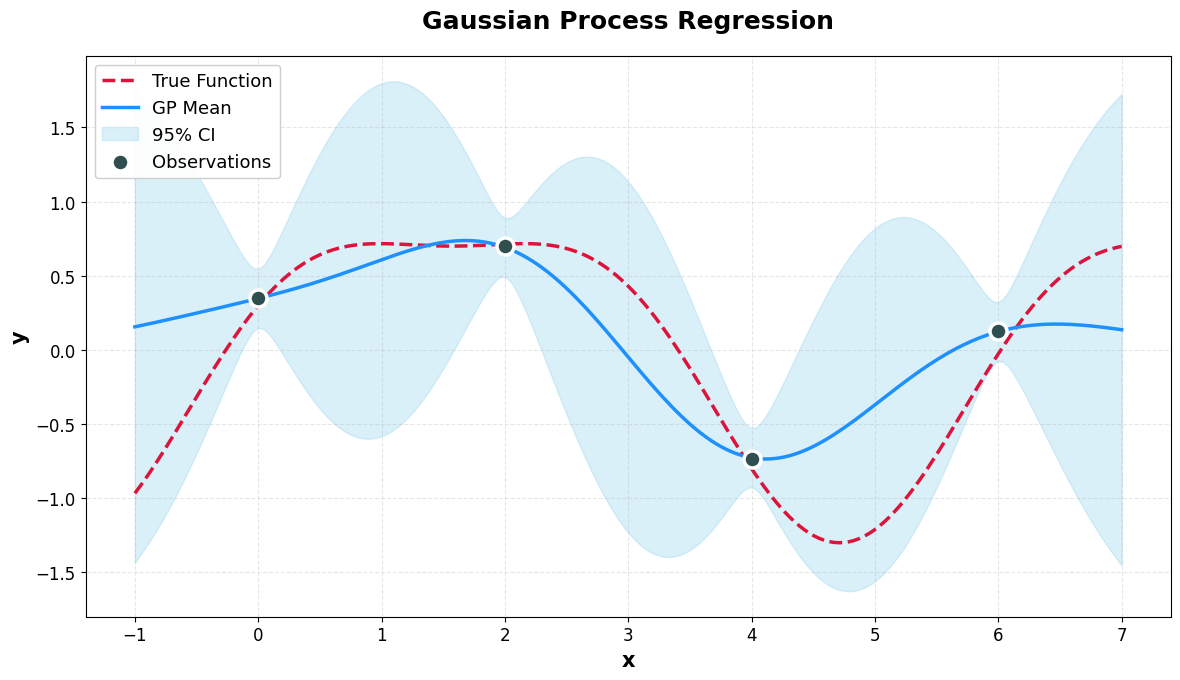


Fitted GP with 4 observations
Length scale: 1.0
Noise level: 0.01


In [9]:
def true_function(x):
    return np.sin(x) + 0.3 * np.cos(2 * x)

np.random.seed(42)
X_train = np.array([0, 2, 4, 6]).reshape(-1, 1)
y_train = true_function(X_train) + np.random.normal(0, 0.1, X_train.shape)

gp = GaussianProcess(length_scale=1.0, noise=0.01)
gp.fit(X_train, y_train)

X_test = np.linspace(-1, 7, 200).reshape(-1, 1)
y_pred, y_std = gp.predict(X_test)
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(X_test, true_function(X_test), 
        color=COLORS['true_function'], linestyle='--', 
        label='True Function', linewidth=2.5)

ax.plot(X_test, y_pred, 
        color=COLORS['prediction'], 
        label='GP Mean', linewidth=2.5)

ax.fill_between(X_test.flatten(), 
                 y_pred - 2*y_std, y_pred + 2*y_std,
                 alpha=0.3, color=COLORS['confidence'], 
                 label='95% CI')

ax.scatter(X_train, y_train, 
           c=COLORS['observed'], s=150, zorder=5, 
           label='Observations', 
           edgecolors='white', linewidths=2.5)

ax.set_xlabel('x', fontsize=15, fontweight='bold')
ax.set_ylabel('y', fontsize=15, fontweight='bold')
ax.set_title('Gaussian Process Regression', 
             fontsize=18, fontweight='bold', pad=20)
ax.legend(fontsize=13, loc='upper left', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nFitted GP with {len(X_train)} observations")
print(f"Length scale: {gp.length_scale}")
print(f"Noise level: {gp.noise}")

## 2. Acquisition Functions

Acquisition functions help decide which point to sample next.

Three popular types:
1. **Probability of Improvement (PI)**: Probability of improvement
2. **Expected Improvement (EI)**: Expected improvement
3. **Lower Confidence Bound (LCB)**: Lower bound of confidence interval

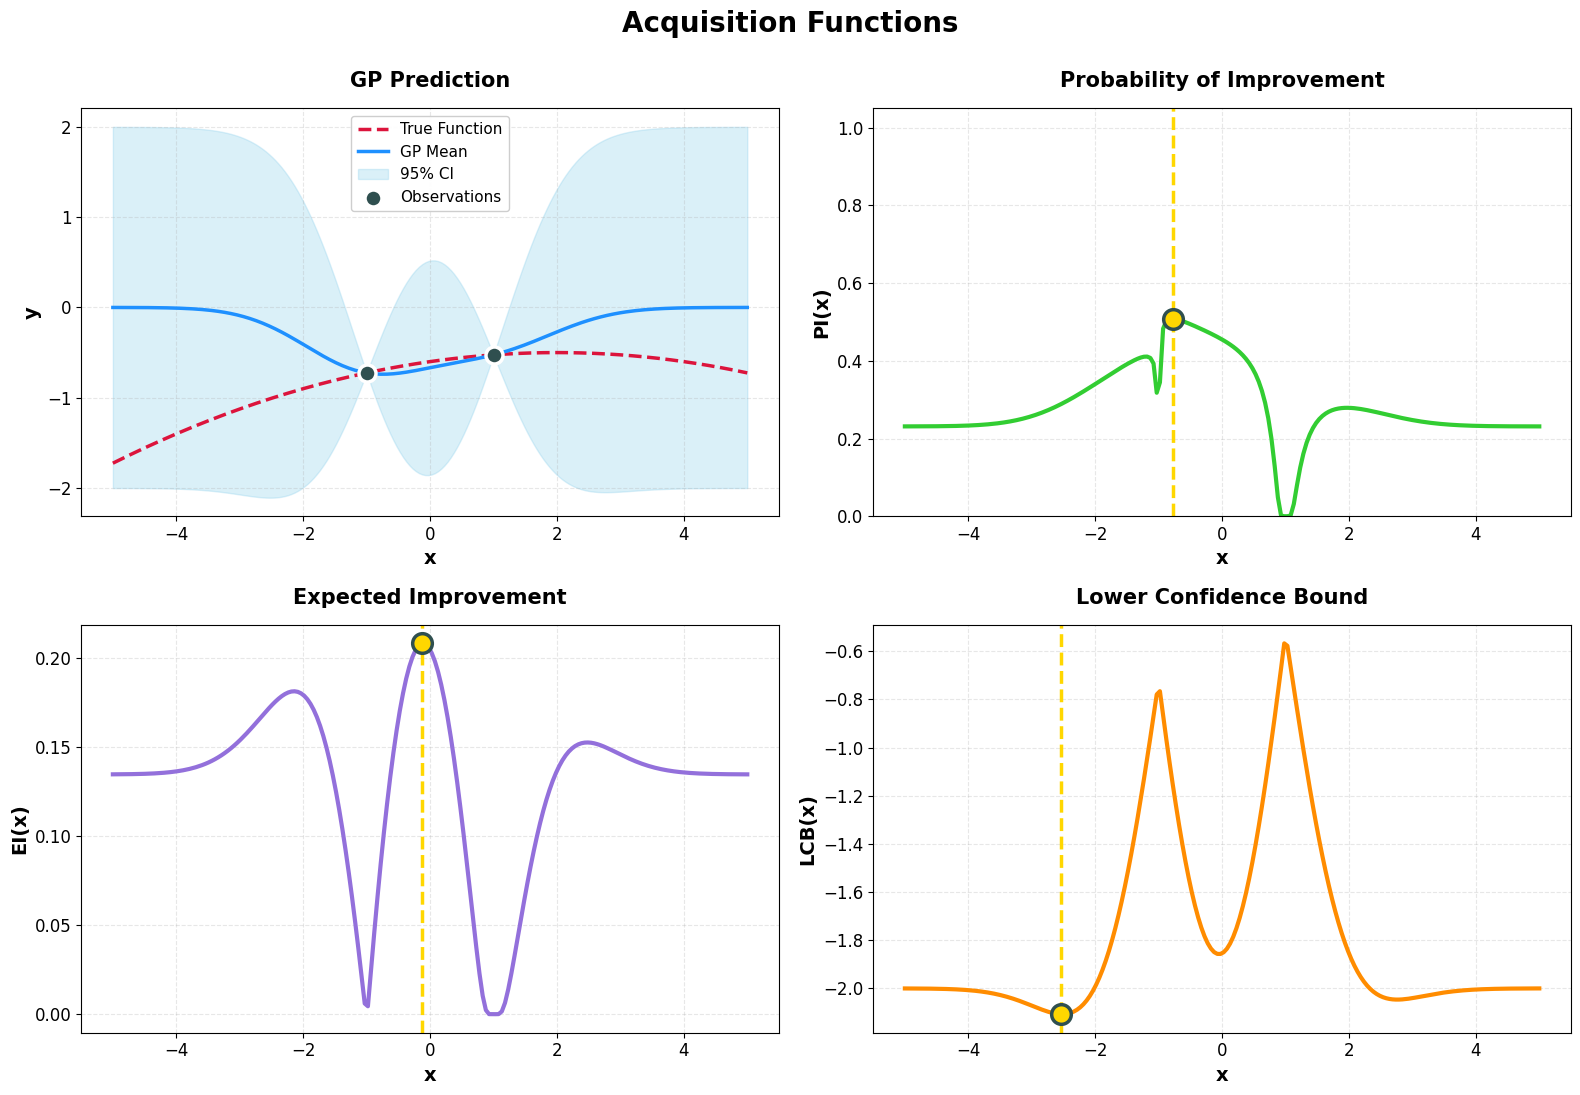


Suggested points:
	PI:  x = -0.78
	EI:  x = -0.13
	LCB: x = -2.54


In [10]:
def objective(x):
    return -(x - 2) ** 2 / 40 - 0.5

X_train_acq = np.array([-1, 1]).reshape(-1, 1)
y_train_acq = objective(X_train_acq)

gp_acq = GaussianProcess(length_scale=1.0, noise=1e-6)
gp_acq.fit(X_train_acq, y_train_acq)

X_test_acq = np.linspace(-5, 5, 200).reshape(-1, 1)
mean_acq, std_acq = gp_acq.predict(X_test_acq)
y_best_acq = y_train_acq.min()

pi = probability_of_improvement(mean_acq, std_acq, y_best_acq)
ei = expected_improvement(mean_acq, std_acq, y_best_acq)
lcb = lower_confidence_bound(mean_acq, std_acq, alpha=2.0)
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Acquisition Functions', fontsize=20, fontweight='bold', y=0.995)

ax = axes[0, 0]
ax.plot(X_test_acq, objective(X_test_acq), 
        color=COLORS['true_function'], linestyle='--', 
        label='True Function', linewidth=2.5)
ax.plot(X_test_acq, mean_acq, 
        color=COLORS['prediction'], 
        label='GP Mean', linewidth=2.5)
ax.fill_between(X_test_acq.flatten(), 
                mean_acq - 2*std_acq, mean_acq + 2*std_acq,
                alpha=0.3, color=COLORS['confidence'], 
                label='95% CI')
ax.scatter(X_train_acq, y_train_acq, 
           c=COLORS['observed'], s=150, zorder=5,
           label='Observations', 
           edgecolors='white', linewidths=2.5)
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('y', fontsize=14, fontweight='bold')
ax.set_title('GP Prediction', fontsize=15, fontweight='bold', pad=15)
ax.legend(fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Plot 2: PI
ax = axes[0, 1]
ax.plot(X_test_acq, pi, color=COLORS['safe'], linewidth=3)
max_pi_idx = np.argmax(pi)
ax.axvline(X_test_acq[max_pi_idx], color=COLORS['highlight'], 
           linestyle='--', linewidth=2.5)
ax.scatter([X_test_acq[max_pi_idx]], [pi[max_pi_idx]], 
           c=COLORS['highlight'], s=200, zorder=5,
           edgecolors=COLORS['observed'], linewidths=2.5)
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('PI(x)', fontsize=14, fontweight='bold')
ax.set_title('Probability of Improvement', fontsize=15, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([0, 1.05])

# Plot 3: EI
ax = axes[1, 0]
ax.plot(X_test_acq, ei, color=COLORS['acquisition'], linewidth=3)
max_ei_idx = np.argmax(ei)
ax.axvline(X_test_acq[max_ei_idx], color=COLORS['highlight'], 
           linestyle='--', linewidth=2.5)
ax.scatter([X_test_acq[max_ei_idx]], [ei[max_ei_idx]], 
           c=COLORS['highlight'], s=200, zorder=5,
           edgecolors=COLORS['observed'], linewidths=2.5)
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('EI(x)', fontsize=14, fontweight='bold')
ax.set_title('Expected Improvement', fontsize=15, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')

# Plot 4: LCB
ax = axes[1, 1]
ax.plot(X_test_acq, lcb, color='#FF8C00', linewidth=3)
min_lcb_idx = np.argmin(lcb)
ax.axvline(X_test_acq[min_lcb_idx], color=COLORS['highlight'], 
           linestyle='--', linewidth=2.5)
ax.scatter([X_test_acq[min_lcb_idx]], [lcb[min_lcb_idx]], 
           c=COLORS['highlight'], s=200, zorder=5,
           edgecolors=COLORS['observed'], linewidths=2.5)
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('LCB(x)', fontsize=14, fontweight='bold')
ax.set_title('Lower Confidence Bound', fontsize=15, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nSuggested points:")
print(f"\tPI:  x = {X_test_acq[np.argmax(pi)][0]:.2f}")
print(f"\tEI:  x = {X_test_acq[np.argmax(ei)][0]:.2f}")
print(f"\tLCB: x = {X_test_acq[np.argmin(lcb)][0]:.2f}")

## 3. Bayesian Optimization

Bayesian Optimization combines GP and acquisition functions to optimize with minimal function evaluations.

Workflow:
1. Initialize with random points
2. Fit GP with current data
3. Optimize acquisition function to find next point
4. Sample new point
5. Update GP and repeat

In [11]:
def objective_bo(x):
    return (x - 2) ** 2 / 40 - 0.5

optimizer = SurrogateOptimizer(
    objective_func=objective_bo,
    bounds=[(-5, 5)],
    acquisition='ei',
    gp_params={'length_scale': 1.0, 'noise': 1e-6}
)

X_best, y_best, history = optimizer.optimize(
    n_init=3,
    n_iter=12,
    random_state=42,
    verbose=True
)

print(f"\nOptimization results:")
print(f"\tx* = {float(X_best[0]):.4f}")
print(f"\tf(x*) = {float(y_best[0]):.4f}")
print(f"\tTrue optimum: f(2) = {objective_bo(2):.4f}")

Bayesian Optimization

Random initialization: 3 points
Acquisition function: EI

Iter  1/12: x =  1.7252, y = -0.4981, best_y = -0.4981
Iter  2/12: x =  1.7651, y = -0.4986, best_y = -0.4986
Iter  3/12: x =  2.2898, y = -0.4979, best_y = -0.4986
Iter  4/12: x =  1.6422, y = -0.4968, best_y = -0.4986
Iter  5/12: x =  2.2866, y = -0.4979, best_y = -0.4986
Iter  6/12: x =  1.6474, y = -0.4969, best_y = -0.4986
Iter  7/12: x =  2.2849, y = -0.4980, best_y = -0.4986
Iter  8/12: x =  2.2862, y = -0.4980, best_y = -0.4986
Iter  9/12: x =  1.6413, y = -0.4968, best_y = -0.4986
Iter 10/12: x =  2.2847, y = -0.4980, best_y = -0.4986
Iter 11/12: x =  1.6219, y = -0.4964, best_y = -0.4986
Iter 12/12: x =  2.2810, y = -0.4980, best_y = -0.4986


Optimization results:
	x* = 1.7651
	f(x*) = -0.4986
	True optimum: f(2) = -0.5000


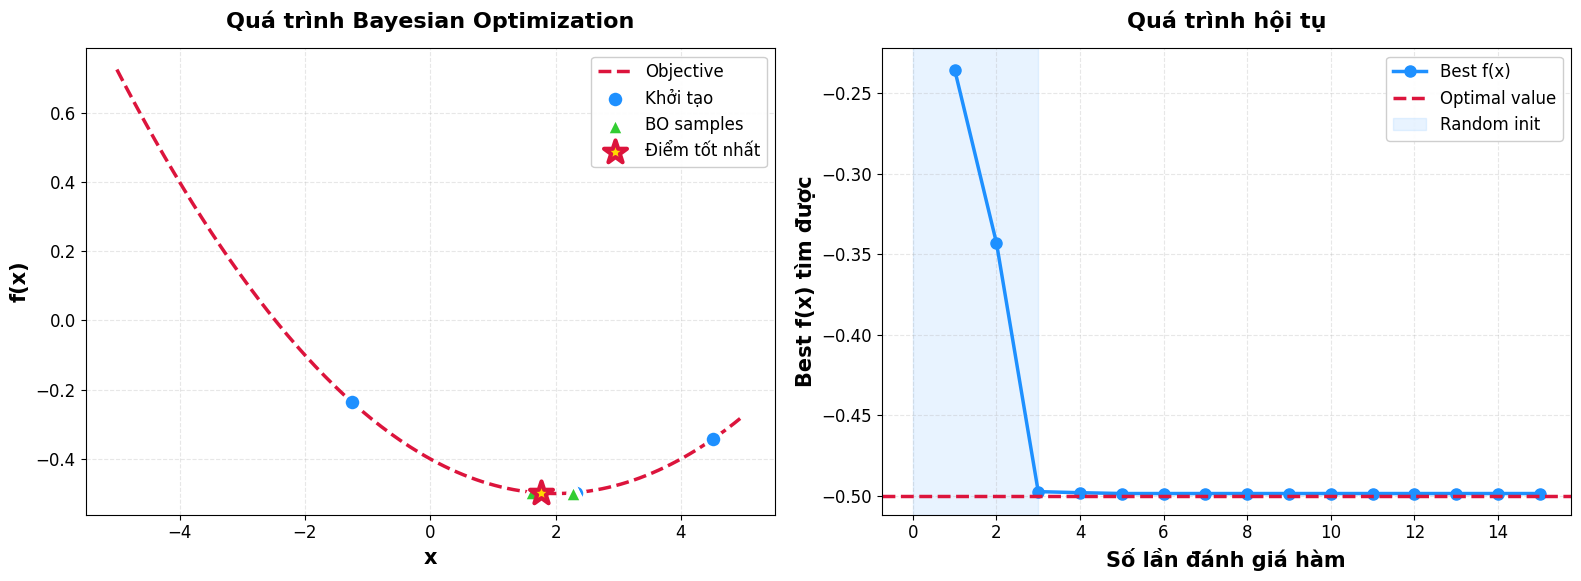

In [12]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Optimization progress
ax = axes[0]
X_test_bo = np.linspace(-5, 5, 200)
y_test_bo = objective_bo(X_test_bo)

ax.plot(X_test_bo, y_test_bo, 
        color=COLORS['true_function'], linestyle='--', 
        label='Objective', linewidth=2.5)

all_X = np.concatenate(history['X'])
all_y = np.concatenate(history['y'])
n_init = len(history['X'][0])

ax.scatter(all_X[:n_init], all_y[:n_init], 
           c=COLORS['prediction'], s=150, marker='o',
           label='Khởi tạo', zorder=5,
           edgecolors='white', linewidths=2.5)

if len(all_X) > n_init:
    ax.scatter(all_X[n_init:], all_y[n_init:], 
               c=COLORS['safe'], s=150, marker='^',
               label='BO samples', zorder=5,
               edgecolors='white', linewidths=2.5)

ax.scatter([X_best[0]], [y_best], 
           c=COLORS['highlight'], s=300, marker='*',
           label='Điểm tốt nhất', zorder=6,
           edgecolors=COLORS['true_function'], linewidths=3)

ax.set_xlabel('x', fontsize=15, fontweight='bold')
ax.set_ylabel('f(x)', fontsize=15, fontweight='bold')
ax.set_title('Quá trình Bayesian Optimization', 
             fontsize=16, fontweight='bold', pad=15)
ax.legend(fontsize=12, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Convergence
ax = axes[1]
best_so_far = [np.min(all_y[:i+1]) for i in range(len(all_y))]

ax.plot(range(1, len(best_so_far) + 1), best_so_far,
        color=COLORS['prediction'], marker='o',
        linewidth=2.5, markersize=8,
        label='Best f(x)')

ax.axhline(y=objective_bo(2), 
           color=COLORS['true_function'], linestyle='--',
           linewidth=2.5, label='Optimal value')

ax.axvspan(0, n_init, alpha=0.1, color=COLORS['prediction'],
           label='Random init')

ax.set_xlabel('Số lần đánh giá hàm', fontsize=15, fontweight='bold')
ax.set_ylabel('Best f(x) tìm được', fontsize=15, fontweight='bold')
ax.set_title('Quá trình hội tụ', fontsize=16, fontweight='bold', pad=15)
ax.legend(fontsize=12, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## 4. Safe Optimization (SafeOpt)

SafeOpt optimizes while ensuring safety: `f(x) <= y_max`

Applications:
- Robot control (avoid collisions)
- Dangerous system optimization
- Medical experiments (avoid harm)

Key ideas:
- Only sample in safe set S
- Balance between minimizing and expanding safe set

In [13]:
def objective_safe(x):
    if isinstance(x, np.ndarray):
        x = x.flatten()[0]
    return np.sin(2 * x) + 0.3 * x

np.random.seed(42)
X_grid = np.linspace(-3, 3, 100).reshape(-1, 1)
y_true_safe = np.array([objective_safe(x) for x in X_grid])
y_max = 0.5

x_init_idx = 50

gp_safe = GaussianProcess(length_scale=0.5, noise=0.01)
safe_opt = SafeOpt(
    gp=gp_safe,
    bounds=[(-3, 3)],
    y_max=y_max,
    beta=9.0,
    p_safe=0.95
)

X_best_safe, y_best_safe, history_safe = safe_opt.optimize(
    X_grid=X_grid,
    objective_func=objective_safe,
    x_init_idx=x_init_idx,
    max_iter=8,
    verbose=True
)

print(f"\nSafeOpt results:")
print(f"\tx* (safe) = {X_best_safe.flatten()[0]:.4f}")
print(f"\tUpper bound: y* <= {y_best_safe:.4f}")

SafeOpt - Safe Optimization

Safety threshold: y_max = 0.5
Beta: 9.0, P_safe: 0.95
Initial point: x = [0.03030303], y = 0.0697

Iter  1: x = -0.0909, y = -0.2081, safe=  5, M= 5, E= 0
Iter  2: x = -0.5152, y = -1.0120, safe= 11, M=11, E= 0
Iter  3: x = -1.0000, y = -1.2093, safe= 19, M=14, E= 2
Iter  4: x = -1.4242, y = -0.7162, safe= 26, M=20, E= 3
Iter  5: x = -1.7273, y = -0.2103, safe= 31, M=24, E= 3
Iter  6: x = -1.9091, y =  0.0534, safe= 34, M=19, E= 6
Iter  7: x = -2.0303, y =  0.1859, safe= 36, M=19, E= 5
Iter  8: x =  0.0909, y =  0.2081, safe= 37, M=19, E= 4


SafeOpt results:
	x* (safe) = -0.9394
	Upper bound: y* <= -0.9288


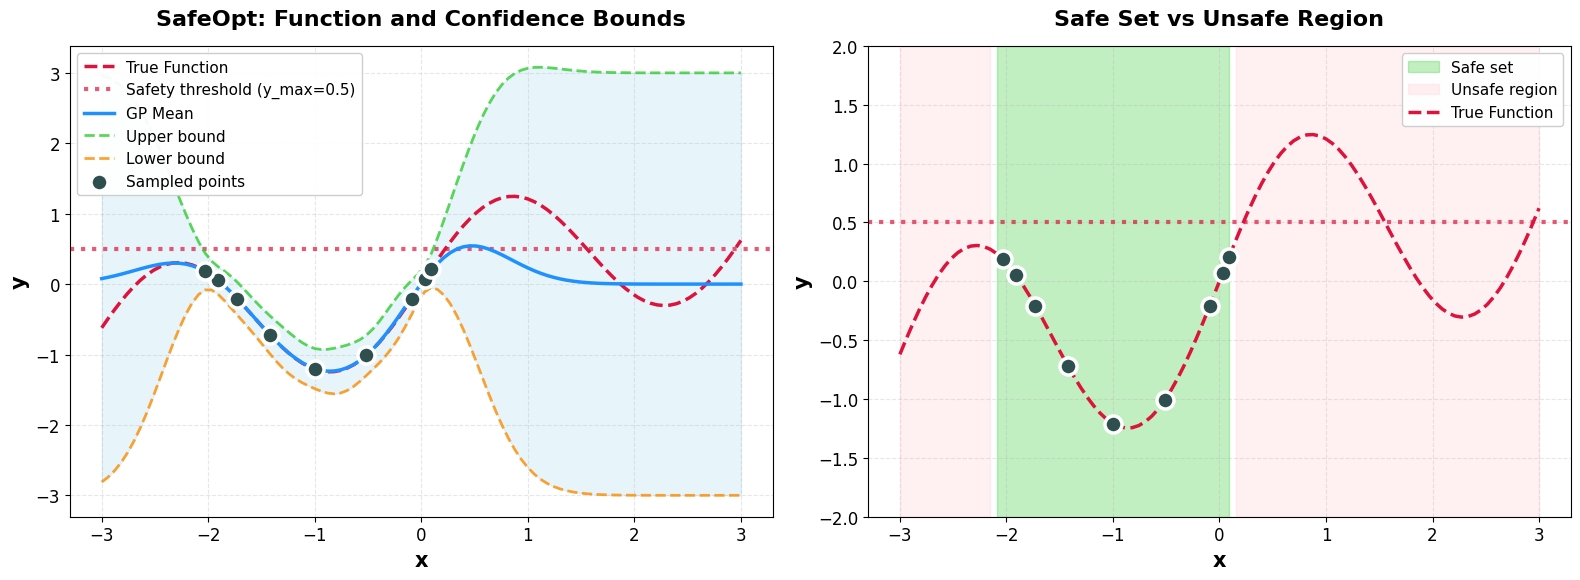

In [14]:

u, l = safe_opt._confidence_bounds(X_grid)
safe_mask = history_safe['safe_sets'][-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
ax.plot(X_grid, y_true_safe, 
        color=COLORS['true_function'], linestyle='--',
        label='True Function', linewidth=2.5)
ax.axhline(y=y_max, color=COLORS['true_function'], 
           linestyle=':', linewidth=3, alpha=0.7,
           label=f'Safety threshold (y_max={y_max})')

mean_safe, std_safe = safe_opt.gp.predict(X_grid)
ax.plot(X_grid, mean_safe, color=COLORS['prediction'],
        label='GP Mean', linewidth=2.5)
ax.plot(X_grid, u, color=COLORS['safe'], linestyle='--',
        label='Upper bound', linewidth=2, alpha=0.8)
ax.plot(X_grid, l, color='#FF8C00', linestyle='--',
        label='Lower bound', linewidth=2, alpha=0.8)
ax.fill_between(X_grid.flatten(), l, u, 
                alpha=0.2, color=COLORS['confidence'])

X_samples_safe = np.array([float(h) if isinstance(h, (int, float, np.number)) else h.flatten()[0] for h in history_safe['X']])
y_samples_safe = np.array(history_safe['y'])
ax.scatter(X_samples_safe, y_samples_safe,
           c=COLORS['observed'], s=150, zorder=5,
           label='Sampled points',
           edgecolors='white', linewidths=2.5)

ax.set_xlabel('x', fontsize=15, fontweight='bold')
ax.set_ylabel('y', fontsize=15, fontweight='bold')
ax.set_title('SafeOpt: Function and Confidence Bounds',
             fontsize=16, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='upper left', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

ax = axes[1]
ax.fill_between(X_grid.flatten(), -2, 2, where=safe_mask,
                alpha=0.3, color=COLORS['safe'],
                label='Safe set')
ax.fill_between(X_grid.flatten(), -2, 2, where=~safe_mask,
                alpha=0.2, color=COLORS['unsafe'],
                label='Unsafe region')

ax.plot(X_grid, y_true_safe, 
        color=COLORS['true_function'], linestyle='--',
        label='True Function', linewidth=2.5, zorder=3)
ax.axhline(y=y_max, color=COLORS['true_function'],
           linestyle=':', linewidth=3, alpha=0.7, zorder=2)
ax.scatter(X_samples_safe, y_samples_safe,
           c=COLORS['observed'], s=150, zorder=5,
           edgecolors='white', linewidths=2.5)

ax.set_xlabel('x', fontsize=15, fontweight='bold')
ax.set_ylabel('y', fontsize=15, fontweight='bold')
ax.set_title('Safe Set vs Unsafe Region',
             fontsize=16, fontweight='bold', pad=15)
ax.legend(fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([-2, 2])

plt.tight_layout()
plt.show()

## 5. Conclusion

Key Points:

1. **Gaussian Process**: Probabilistic model for unknown functions with uncertainty estimates

2. **Acquisition Functions**: Balance exploration and exploitation
   - **EI** usually gives best results
   - **LCB** easy to tune via alpha
   - **PI** simple but less effective

3. **Bayesian Optimization**: Efficient optimization with few function evaluations
   - Suitable for expensive function evaluations
   - Hyperparameter tuning, AutoML, etc.

4. **SafeOpt**: Safe optimization with constraints
   - Ensures safety threshold not violated
   - Applications: robotics, dangerous systems, medicine

Real-world Applications:
- Machine Learning: Hyperparameter tuning
- Robotics: Safe controller optimization
- Manufacturing: Process optimization
- Drug Discovery: Molecular search
- A/B Testing: Marketing optimization

## References

1. Kochenderfer & Wheeler - *Algorithms for Optimization* (2019), Chapter 19
2. Rasmussen & Williams - *Gaussian Processes for Machine Learning* (2006)
3. Sui et al. - "Safe Exploration for Optimization with Gaussian Processes" (ICML 2015)
4. Shahriari et al. - "Taking the Human Out of the Loop: A Review of Bayesian Optimization" (2016)